# Biggest loser strategy

**Author:** Kuo Liang  
**Date:** October 17, 2025  
**Purpose:** A concise description of the notebook's objective. For example: "This notebook explores the California housing prices dataset to build a predictive model."  
**Data Source(s):** [perplexity, yahoo finance]  
**Environment:** [Python 3.12, JupyterLab 4.4.9]  

## Overview
This section provides a high-level summary of the notebook's contents.

1.  **Data Loading and Inspection:** Import necessary libraries and load the raw data.
2.  **Exploratory Data Analysis (EDA):** Visualize key variables and identify patterns.
3.  **Data Preprocessing:** Clean the data and prepare it for modeling.
4.  **Model Training:** Train and evaluate a [e.g., Linear Regression] model.
5.  **Conclusion:** Summarize findings and next steps.


In [1]:
### Background: d(TODO explain why this repo exit)

In [10]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rich.traceback import install
import seaborn as sns
from tqdm.notebook import tqdm
import yfinance as yf # 0.2.54 version


install()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [2]:
ticker_df = pd.read_csv("data/tickers_10_sectors.csv")
ticker_df.head(2)

,Sector,Ticker 1,Ticker 2,Ticker 3,Ticker 4,Ticker 5,Ticker 6,Ticker 7,Ticker 8,Ticker 9,Ticker 10
0,Information Technology,MSFT,AAPL,NVDA,AMD,CRM,INTC,TSM,ORCL,AVGO,CSCO
1,Health Care,JNJ,PFE,UNH,MRK,ABBV,LLY,TMO,BMY,CVS,DHR


In [3]:
tick_lst_dict = dict()  # create a dictionary to hold the list of tickers

# Get all rows as Python lists
rows_as_lists = ticker_df.values.tolist()

# make key value pair for tickers and sectors
for row in rows_as_lists:
    tick_lst_dict[row[0]] = row[1:]

In [4]:
#### Not to abuse the API, just query it once

all_ticks = [tick for sector_ticks in tick_lst_dict.values() for tick in sector_ticks]
all_ticks.append('^SPX') # get S&P 500 index there for benchmarking

# download the prices for all tickers with start date
all_data = yf.download(all_ticks, start='2015-01-01', auto_adjust=False)

# get month end price for tickers has price listed on yahoo finance
month_end_prices = all_data.dropna(axis=1, how='any').resample('ME').last()['Adj Close'].copy()

[*********************100%***********************]  111 of 111 completed

2 Failed downloads:
['BRK.B', 'ATVI']: YFTzMissingError('possibly delisted; no timezone found')


### The simulation begins

In [5]:
# clean the data list to keep tickers have data
valid_ticks = month_end_prices.columns.tolist()

for k, v in tick_lst_dict.items():
    tick_lst_dict[k] = [tk for tk in v if tk in valid_ticks]

In [6]:
def get_tickers(tick_lst_dict):
    sec_num_selection = {'Information Technology' : 1,
                         'Health Care' : 1,
                         'Financials' : 1,
                         'Consumer Discretionary' : 1,
                         'Communication Services' : 1,
                         'Industrials' : 1,
                         'Energy' : 1,
                         'Consumer Staples' : 1,
                         'Utilities' : 1,
                         'Real Estate' : 1,
                         'Materials' : 1}
    sel_cols = []
    for k, v in sec_num_selection.items():
        sel_cols.extend(random.sample(tick_lst_dict[k], k=v))
    
    return sel_cols

def sim_strategy(sel_df, use_cols, invest_amt=500):
    
    perc_ch_df = sel_df[use_cols].pct_change().dropna()
    perc_ch_df['biggest_loser'] = perc_ch_df.idxmin(axis=1)
    sel_df['To_buy'] = perc_ch_df['biggest_loser']
    sel_df.dropna(inplace=True)
    
    # before assigning actual shares to buy, set them to 0
    for col in use_cols:
        sel_df[f'{col}_to_buy'] = 0.0
    
    # assign number of shares to buy for each stock
    for col in use_cols:
        indx = sel_df[sel_df['To_buy'] == col].index.values
        sel_df.loc[indx, f'{col}_to_buy'] = (invest_amt / sel_df.loc[indx, col]).round(6)
        
    # get cumulative shares for the stocks
    for col in use_cols:
        sel_df[f'{col}_cum_shares'] = sel_df[f'{col}_to_buy'].cumsum()
    
    # get the cumulative values for each stock
    for col in use_cols:
        sel_df[f'{col}_cum_values'] = sel_df[f'{col}_cum_shares'] * sel_df[col]
    
    sel_df['invest_amount'] = invest_amt
    sel_df['cum_invest_amount'] = sel_df['invest_amount'].cumsum()
    sel_df['tota_cum_value'] = sel_df[[f'{col}_cum_values' for col in use_cols]].sum(axis=1)
    
    # get the shares if I keep buying only one stocks
    new_use_cols = use_cols + ['^SPX'] # add s&p back to the df
    
    for col in new_use_cols:
        sel_df[f'only_buy_{col}_shares'] = (invest_amt / sel_df[col]).round(6)
    
    # get the cumulative shares 
    for col in new_use_cols:
        sel_df[f'only_buy_{col}_cum_values'] = sel_df[f'only_buy_{col}_shares'].cumsum()
    
    # get the values for persistent evaluate
    for col in new_use_cols:
        sel_df[f'only_buy_{col}_value'] = sel_df[f'only_buy_{col}_cum_values'] * sel_df[col]
    
    return sel_df

def save_chart(plot_df, use_cols, indx, show_plot=False):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))
    
    # Plot all gray lines first
    for col in plot_df.columns:
        if col not in ['cum_invest_amount', 'tota_cum_value', 'only_buy_^SPX_value']:
            plt.plot(plot_df.index, plot_df[col], color='gray', alpha=0.5, linewidth=1)
    
    # Plot cost, trategy, S&P500 with specific colors
    plt.plot(plot_df.index, plot_df['tota_cum_value'], color='red', linewidth=2, label='Biggest Loser Strategy')
    plt.plot(plot_df.index, plot_df['cum_invest_amount'], color='blue', linewidth=2, label='Cost')
    plt.plot(plot_df.index, plot_df['only_buy_^SPX_value'], color='green', linewidth=2, label='S&P500')
    
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Biggest Loser Strategy Performance vs Single Stock Dollar Averaging')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add note at bottom right of entire figure
    plt.figtext(0.99, 0.01, f'Stocks: {", ".join(use_cols)}',
                ha='right', va='bottom',
                fontsize=8, style='italic')
    
    plt.tight_layout()
    plt.savefig(f'Pictues/big_loser_lines_{indx}.png', dpi=100, bbox_inches='tight')
    if show_plot:
        plt.show()
    else:
        plt.close()


In [20]:
# let's do 30 runs, since that's the number for minimium sample size to be statistially significant
for indx in tqdm(range(1, 31)):
    # get the df for the simulation
    use_cols = get_tickers(tick_lst_dict)
    sel_df = month_end_prices[use_cols + ['^SPX']].copy()
    
    compute_df = sim_strategy(sel_df, use_cols, 500)
    
    # save the plots 
    plot_cols = ['cum_invest_amount', 'tota_cum_value'] + [f"only_buy_{col}_value" for col in use_cols] + ["only_buy_^SPX_value" ]
    plot_df = compute_df[plot_cols]
    save_chart(plot_df, use_cols, indx, False)
    
    # save the ranking result 
    result_cols = ['tota_cum_value', "only_buy_^SPX_value"] + [f"only_buy_{col}_value" for col in use_cols]
    result_df = compute_df[result_cols].iloc[-1].to_frame(name='final_values').reset_index().sort_values('final_values', ascending=False)
    result_df['rank'] = np.arange(1, len(result_df)+1)
    result_df.to_csv(f'results/big_loser_strat_{indx}.csv', index=False)

  0%|          | 0/30 [00:00<?, ?it/s]

## Ranking summary

In [39]:
result_df_lst = []
for ind in range(1,31):
    
    result_df = pd.read_csv(f'results/big_loser_strat_{ind}.csv')
    result_df['from_trail'] = ind
    result_df['total_candidate'] = len(result_df)
    result_df_lst.append(result_df[result_df['Ticker'] == 'tota_cum_value'])

total_result_df = pd.concat(result_df_lst)

rank_df = total_result_df['rank'].value_counts().to_frame().reset_index()
rank_df.sort_values('rank', inplace=True)

# making sure all of the results have 13 rankings
print("make sure all of the results have 13 rankings")
total_result_df['total_candidate'].value_counts()

make sure all of the results have 13 rankings


total_candidate
13    30
Name: count, dtype: int64

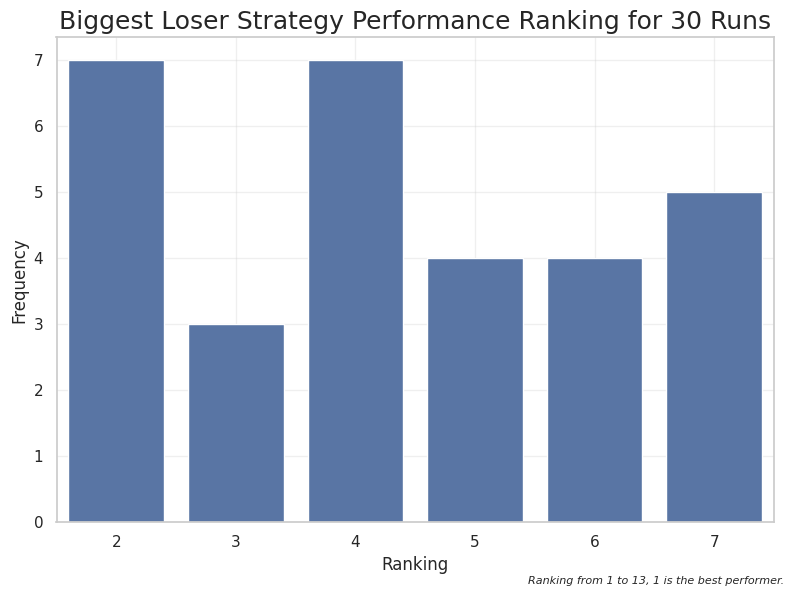

In [38]:
plt.figure(figsize=(8, 6))

sns.barplot(data=rank_df, x='rank', y='count')

plt.xlabel('Ranking')
plt.ylabel('Frequency')
plt.title('Biggest Loser Strategy Performance Ranking for 30 Runs', fontsize=18)
# plt.legend()

plt.grid(True, alpha=0.3)

# Add note at bottom right of entire figure
plt.figtext(0.99, 0.01, 'Ranking from 1 to 13, 1 is the best performer.',
            ha='right', va='bottom',
            fontsize=8, style='italic')

plt.tight_layout()
plt.savefig(f'Pictues/Results_big_loser_ranking_30_runs.png', dpi=100, bbox_inches='tight')
plt.show()
